In [1]:
import os
import argparse

import numpy as np
from scipy import stats
from six.moves import cPickle
import hickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True

pre_frames = 10 # 50
stim_frames = 20 # 80
post_frames = 20 # 100

n_movies = 100
batch_size = 1

SAVE_DIR = './response/190724_11/'

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def classify(resp):
    """
    resp: (2, n_movies, nt, n_units)
    """

    ramping_idx = [] # rampup cell
    ma_idx = [] # motion aftereffect cell
    ma_idx_sep = [[], []]
    error_idx = [] # pred error cell
    motion_idx = [] # motion cell
    motion_idx_sep = [[], []]
    flat_idx = [] # non-responsive cell
 
    nt2 = stim_frames + post_frames  
 
    # responsiveness
    resp_mean = np.mean(resp, axis=1) # (2, nt, n_units)
    resp_std = np.std(resp, axis=1) # (2, nt, n_units)
    
    base_mean = np.mean(resp_mean[:, pre_frames // 2: pre_frames, :], axis=1, keepdims=True) # (2, 1, n_units)
    base_std =  np.mean(resp_std[:,  pre_frames // 2: pre_frames, :], axis=1, keepdims=True) # (2, 1, n_units)
    
    """
    # non-responsive cell
    sign = (np.abs(resp_mean[:, pre_frames:, :] - base_mean) > (resp_std[:, pre_frames:, :] + base_std) * 0.5) # (2, 180, n_units)
    c = np.sum(sign, axis=1) < nt2 * 0.1 # (2, n_units)
    flat_idx = np.where(np.sum(c, axis=0) == n_stims)[0]"""
    
    d_resp = np.abs(resp_mean[:, pre_frames:, :] - base_mean)
    d_resp = np.where(d_resp > (resp_std[:, pre_frames:, :] + base_std) * 0.5, d_resp, 0) # (2, 180, n_units)
    
    # non-responsive cell
    c = np.sum(d_resp != 0, axis=1) < nt2 * 0.1 # (2, n_units)
    flat_idx = np.where(np.sum(c, axis=0) == n_stims)[0]
    non_flat_idx = [c for c in range(d_resp.shape[2]) if c not in flat_idx]
    
    # standardization
    # d_resp[:, :, non_flat_idx] -= np.mean(d_resp[:, :, non_flat_idx], axis=-1, keepdims=True)
    # d_resp[:, :, non_flat_idx] /= np.std(d_resp[:, :, non_flat_idx], axis=-1, keepdims=True)

    for idx in tqdm(non_flat_idx):
        _resp = d_resp[:, :, idx] # (2, 180)
        
        # error cell
        m1 = np.mean(_resp[:, :2], axis=-1)
        m2 = np.mean(_resp[:, stim_frames: stim_frames + 2], axis=-1)
        m3 = np.mean(_resp[:, list(range(2, stim_frames)) + list(range(stim_frames + 2, nt2))], axis=-1) # base
        if np.sum(np.logical_or(m1 > 4 * m3, m2 > 4 * m3)):
            error_idx.append(idx)            
        # if np.where(_resp == np.max(_resp))[1][0] in [0, 1, stim_frames, stim_frames+1]:
        #     error_idx.append(idx)

        m1 = np.sum(_resp[0, :stim_frames])
        m2 = np.sum(_resp[0, stim_frames:])
        m3 = np.sum(_resp[1, :stim_frames])
        m4 = np.sum(_resp[1, stim_frames:])
        if n_stims == 4:
            m5 = np.sum(_resp[2, :stim_frames])
            m6 = np.sum(_resp[2, stim_frames:])
            m7 = np.sum(_resp[3, :stim_frames])
            m8 = np.sum(_resp[3, stim_frames:])

        # ramp cell
        resp_smooth = np.mean(_resp.reshape((n_stims, 10, nt2 // 10)), axis=-1) # (2, 10)
        d = np.diff(resp_smooth, axis=-1) # (2, 9)
        s = np.sign(d)[:, :4]
        if np.sum(np.sum(s == 1, axis=-1) >= 3):
            ramping_idx.append(idx)

        # motion cell 
        else:
            if n_stims == 4:
                if (m1 > m2 * 2 and m1 > m3 * 2 and m1 > m4 * 2) or \
                   (m3 > m4 * 2 and m3 > m1 * 2 and m3 > m2 * 2) or \
                   (m5 > m6 * 2 and m5 > m7 * 2 and m5 > m8 * 2) or \
                   (m7 > m8 * 2 and m7 > m5 * 2 and m7 > m6 * 2):
                    motion_idx.append(idx)
            elif n_stims == 2:
                if (m1 > m2 * 2 and m1 > m3 * 2 and m1 > m4 * 2):
                    motion_idx_sep[0].append(idx)
                    motion_idx.append(idx)
                if (m3 > m4 * 2 and m3 > m1 * 2 and m3 > m2 * 2):
                    motion_idx_sep[1].append(idx)
                    motion_idx.append(idx)
                    
        # after motion cell
        if n_stims == 4:
            if (m1 > m3 * 2 and m4 > m2 * 2) or (m3 > m1 * 2 and m2 > m4 * 2) or \
               (m5 > m7 * 2 and m8 > m6 * 2) or (m7 > m5 * 2 and m6 > m8 * 2):
                ma_idx.append(idx)
        elif n_stims == 2:
            if (m1 > m3 * 2 and m4 > m2 * 2):
                ma_idx_sep[0].append(idx)
                ma_idx.append(idx)
            if (m3 > m1 * 2 and m2 > m4 * 2):
                ma_idx_sep[1].append(idx)
                ma_idx.append(idx)
    return d_resp, flat_idx, ramping_idx, ma_idx, error_idx, motion_idx, motion_idx_sep, ma_idx_sep

In [3]:
n_stims = 2
analyze_all = True
# targets = ['E0', 'E1', 'E2', 'R0', 'R1', 'R2', 'A0', 'A1', 'A2', 'Ahat0', 'Ahat1', 'Ahat2']
targets = ['E2', 'A2', 'Ahat2', 'R2']
# targets = ['E0', 'A0', 'Ahat0']
# taregets = ['E1', 'A1', 'Ahat1']
# targets = ['E2']

cell_dict = {}
for target in targets:
    # load all data
    for n in tqdm(range(n_movies // batch_size)):
        resp_deg0 = hickle.load(SAVE_DIR + 'MAE_P_deg0_' + target + '_' + str(n) + '.hkl') # (batch_size, 230, 12, 14, 192)
        resp_deg180 = hickle.load(SAVE_DIR + 'MAE_P_deg180_' + target + '_' + str(n) + '.hkl')
        if n_stims == 4:
            resp_deg90 = hickle.load(SAVE_DIR + 'MAE_P_deg90_' + target + '_' + str(n) + '.hkl')
            resp_deg270 = hickle.load(SAVE_DIR + 'MAE_P_deg270_' + target + '_' + str(n) + '.hkl')
            
        if n == 0:
            resp = np.zeros((n_stims, n_movies, ) + resp_deg0.shape[1:]) # (2, 100, 230, 12, 14, 192)
            
        resp[0, n * batch_size: (n+1) * batch_size] = resp_deg0
        resp[1, n * batch_size: (n+1) * batch_size] = resp_deg180
        if n_stims == 4:
            resp[2, n * batch_size: (n+1) * batch_size] = resp_deg90
            resp[3, n * batch_size: (n+1) * batch_size] = resp_deg270

    # omit the pre frame
    # resp_ind = np.mean(resp, axis=1)[:, pre_frames:] # (2, 180, 12, 14, 192)
        
    # reshape
    if analyze_all:
        # analyze all units
        n_units = resp.shape[3] * resp.shape[4] * resp.shape[5]
        nt = resp.shape[2]
        resp = resp.reshape((n_stims, n_movies, nt, n_units))
    else:
        # analyze center units
        n_units = resp.shape[-1]
        resp = resp[:, :, :, resp.shape[3]//2, resp.shape[4]//2, :]

    """if 'R' in target:
        tmp1 = np.clip(resp, 0, None)
        tmp2 = np.clip(resp, None, 0) * -1
        resp = np.concatenate((tmp1, tmp2), axis=-1)"""

    print(resp.shape) # (2, 100, 230, n_units)
        
    d_resp, flat_idx, ramping_idx, ma_idx, error_idx, motion_idx, motion_idx_sep, ma_idx_sep = classify(resp)
    cell_dict[target] = [n_units, flat_idx, ramping_idx, ma_idx, error_idx, motion_idx, motion_idx_sep, ma_idx_sep]
    
# summary
n_cells = np.zeros((len(targets), 6))
for i, target in enumerate(targets):
    n_cells[i][0] = cell_dict[target][0]
    for j in range(1, 6):
        n_cells[i][j] = len(cell_dict[target][j])
        
for i in range(len(n_cells)):
    n1 = n_cells[i, 0] - n_cells[i, 1] - n_cells[i, 4]
    n2 = n_cells[i, 0] - n_cells[i, 1]
    print(n_cells[i, 4] / n2 * 100) # error
    print(n_cells[i, 2] / n2 * 100) # ramp
    print(n_cells[i, 3] / n2 * 100) # ma
    print(n_cells[i, 5] / n2 * 100) # motion
    print()

100%|██████████| 100/100 [00:07<00:00, 12.54it/s]


(2, 100, 50, 32256)


100%|██████████| 100/100 [00:05<00:00, 16.15it/s]


(2, 100, 50, 16128)


100%|██████████| 100/100 [00:07<00:00, 19.21it/s]


(2, 100, 50, 16128)


100%|██████████| 100/100 [00:04<00:00, 21.30it/s]


(2, 100, 50, 16128)


100%|██████████| 16005/16005 [00:01<00:00, 9806.26it/s]

69.06727197688815
24.948411060668594
21.00701609574907
43.31407346264961

70.23186237845924
24.707055597107953
22.68760907504363
44.951383694839194

63.08724832214765
25.727069351230426
14.093959731543624
30.87248322147651

18.22555451421431
50.32177444548579
3.542642924086223
20.937207122774133



### save

In [4]:
if analyze_all:
    hickle.dump(cell_dict, SAVE_DIR + 'cell_dict.hkl')
else:
    hickle.dump(cell_dict, SAVE_DIR + 'cell_dict_center.hkl')

### analyze ramp-up cells

In [4]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

idxs = np.array([1,2,5,6,7,14,15,16,18,20,22,23,24,26,28,29,30,32,34,35])
targets_all = np.array(ramping_idx)[idxs]
nt2 = stim_frames + post_frames  

targets1 = []
targets2 = []
for cell in targets_all:
    counter = 0
    
    for t in range(100):
        _resp = resp[0, t, pre_frames:, cell] # (50, )
                
        resp_smooth = np.mean(_resp.reshape((10, nt2 // 10)), axis=-1) # (10)
        d = np.diff(resp_smooth) # (9)
        s = np.sign(d)[:4]
        if np.sum(s == 1) >= 3:
            counter += 1

    if counter <= 50:
        targets1.append(cell)
    else:
        targets2.append(cell)

In [6]:
fig = plt.figure(figsize=(20, 20))
for i, c in enumerate(targets1 + targets2):
    x = np.arange(0, nt)
    ax = plt.subplot(10, 10, i+1)
    for t in range(5):
        ax.plot(x, resp[0, t, :, c], linewidth=0.75)
    ax.axvspan(pre_frames, pre_frames + stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))
    ax.set_title('Cell ' + str(c))

plt.tight_layout()
plt.savefig(SAVE_DIR + 'single_trial_ind.png')
plt.savefig(SAVE_DIR + 'single_trial_ind.pdf')
plt.close()

# plot trial-averaged timecourses
fig = plt.figure(figsize=(20, 20))
for i, c in enumerate(targets1 + targets2):
    _resp1 = np.mean(resp[0, :, :, c], axis=0)
    error1 = np.std(resp[0, :, :, c], axis=0) / 2
    x = np.arange(0, nt)

    ax = plt.subplot(10, 10, i+1)
    ax.plot(x, _resp1, 'm-')
    ax.fill_between(x, _resp1 - error1, _resp1 + error1, facecolor=(1,0,1,0.5), edgecolor=(1,0,1,0.5))
    ax.axvspan(pre_frames, pre_frames + stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))
    ax.set_title('Cell ' + str(c))

plt.tight_layout()
plt.savefig(SAVE_DIR + 'single_trial_taverage.png')
plt.savefig(SAVE_DIR + 'single_trial_taverage.pdf')
plt.close()


# plot cell-averaged timecourses (targets1)
fig = plt.figure(figsize=(20, 20))
for i, t in enumerate(range(20)):
    _resp1 = np.mean(resp[0, t][:, np.array(targets1)], axis=-1)
    x = np.arange(0, nt)

    ax = plt.subplot(10, 10, i+1)
    ax.plot(x, _resp1, 'm-')
    ax.axvspan(pre_frames, pre_frames + stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))
    ax.set_title('Trial ' + str(t))

plt.tight_layout()
plt.savefig(SAVE_DIR + 'single_trial_caverage1.png')
plt.savefig(SAVE_DIR + 'single_trial_caverage1.pdf')
plt.close()

# plot cell-averaged timecourses (targets2)
fig = plt.figure(figsize=(20, 20))
for i, t in enumerate(range(20)):
    _resp1 = np.mean(resp[0, t][:, np.array(targets2)], axis=-1)
    x = np.arange(0, nt)

    ax = plt.subplot(10, 10, i+1)
    ax.plot(x, _resp1, 'm-')
    ax.axvspan(pre_frames, pre_frames + stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))
    ax.set_title('Trial ' + str(t))

plt.tight_layout()
plt.savefig(SAVE_DIR + 'single_trial_caverage2.png')
plt.savefig(SAVE_DIR + 'single_trial_caverage2.pdf')
plt.close()

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica
  (prop.get_family(), self.defaultFamily[fontext]))


### analyze the correlation b/w motion and ma cells

In [4]:
motion_idx_sep = cell_dict['E2'][6]
ma_idx_sep = cell_dict['E2'][7]

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


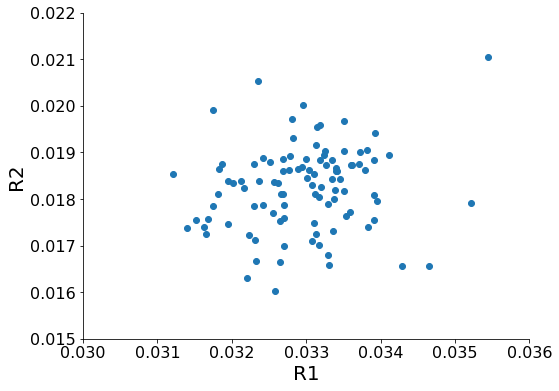

(0.16555667634728363, 0.09973640214389284)


In [9]:
r = resp[0]

# activities of motion cells during motion, averaged across cell
r1 = r[:, np.arange(10, 30), :]
r1 = r1[:, :, np.array(motion_idx_sep[0])]
r1 = np.mean(r1, axis=(1, 2))

# activities of MA cells during after-motion, averaged across cell
r2 = r[:, np.arange(30, 50), :]
r2 = r2[:, :, np.array(ma_idx_sep[1])]
r2 = np.mean(r2, axis=(1, 2))

plt.figure()
plt.scatter(r1, r2)
plt.xlim([0.03, 0.036])
plt.ylim([0.015, 0.022])
plt.xlabel('R1')
plt.ylabel('R2')
plt.show()
print(stats.pearsonr(r1, r2))

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


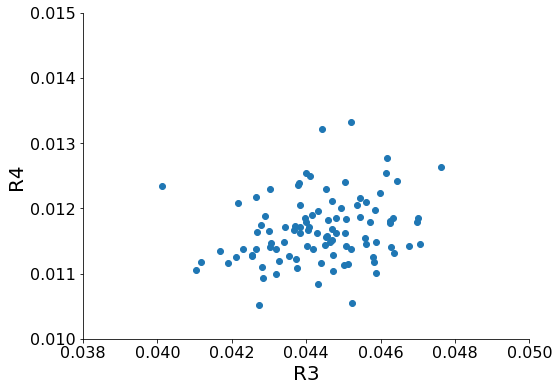

(0.22730133217740844, 0.022948423541939912)


In [15]:
r = resp[1]

# activities of motion cells during motion, averaged across cell
r1 = r[:, np.arange(10, 30), :]
r1 = r1[:, :, np.array(motion_idx_sep[1])]
r1 = np.mean(r1[:-5], axis=(1, 2))

# activities of MA cells during after-motion, averaged across cell
r2 = r[:, np.arange(30, 50), :]
r2 = r2[:, :, np.array(ma_idx_sep[0])]
r2 = np.mean(r2, axis=(1, 2))

plt.figure()
plt.scatter(r1, r2)
plt.xlim([0.038, 0.05])
plt.ylim([0.01, 0.015])
plt.xlabel('R3')
plt.ylabel('R4')
plt.show()
print(stats.pearsonr(r1, r2))

### plot

In [7]:
def plot_one(idx, space):
    _resp1 = np.mean(resp[0, :, :, idx], axis=0)
    error1 = np.std(resp[0, :, :, idx], axis=0) / 2
    _resp2 = np.mean(resp[1, :, :, idx], axis=0)
    error2 = np.std(resp[1, :, :, idx], axis=0) / 2
    x = np.arange(0, nt)

    ax = plt.subplot(10, 10, space)
    ax.plot(x, _resp1, 'm-')
    ax.fill_between(x, _resp1 - error1, _resp1 + error1, facecolor=(1,0,1,0.5), edgecolor=(1,0,1,0.5))
    ax.plot(x, _resp2, 'c-')
    ax.fill_between(x, _resp2 - error2, _resp2 + error2, facecolor=(0,1,1,0.5), edgecolor=(0,1,1,0.5))
    ax.axvspan(pre_frames, pre_frames + stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))

    # title = str(idx)
    title = ''
    if idx in ramping_idx:
        title += 'r'
    if idx in ma_idx:
        title += 'a'
    if idx in motion_idx:
        title += 'm'
    if idx in error_idx:
        title += 'e'
    ax.set_title(title, fontsize=16)

def plotter(idxs, start):
    for i in range(20):
        plot_one(idxs[i], start+i)
        
def plot_one_tmp(idx, space):
    x = np.arange(0, stim_frames + post_frames)
    ax = plt.subplot(10, 10, space)
    ax.plot(x, d_resp[0, :, idx], 'm-')
    ax.plot(x, d_resp[1, :, idx], 'c-')
    ax.axvspan(0, stim_frames - 0.5, facecolor='g', alpha=0.1)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xticks(np.arange(0, nt, 10))

    # title = str(idx)
    title = ''
    if idx in ramping_idx:
        title += 'r'
    if idx in ma_idx:
        title += 'a'
    if idx in motion_idx:
        title += 'm'
    if idx in error_idx:
        title += 'e'
    ax.set_title(title, fontsize=16)

In [8]:
fig = plt.figure(figsize=(20, 20))
plotter(error_idx, 1)
plotter(ramping_idx, 21)
plotter(ma_idx, 41)
plotter(motion_idx, 61)
plt.tight_layout()
plt.savefig(SAVE_DIR + 'tc_eachgroup.png')
plt.savefig(SAVE_DIR + 'tc_eachgroup.pdf')
plt.close()

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica
  (prop.get_family(), self.defaultFamily[fontext]))


In [9]:
fig = plt.figure(figsize=(20, 20))

i = 100
plotted = 0
while True:
    if i not in flat_idx:
        plot_one(i, plotted + 1)        
        plotted += 1
        if plotted == 100:
            break
    i += 1
    
plt.tight_layout()
plt.savefig(SAVE_DIR + 'tc.png')
plt.savefig(SAVE_DIR + 'tc.pdf')
plt.close()

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Helvetica
  (prop.get_family(), self.defaultFamily[fontext]))


# connection

In [81]:
from keras.models import Model, model_from_json
from prednet import PredNet

WEIGHTS_DIR = './model/190724_11/'

weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

In [83]:
w = train_model.get_weights()

for i in range(len(w)):
    print(w[i].shape) # ['a', 'ahat', 'c', 'f', 'i', 'o'] order

# Ramp cells in A0

In [5]:
target = 'A0'
cell_dict = hickle.load(SAVE_DIR + 'cell_dict.hkl')
n_stims = 2

In [6]:
resp_deg0 = hickle.load(SAVE_DIR + 'MAE_P_deg0_' + target + '.hkl') # (10, 50, 12, 14, 192)
resp_deg180 = hickle.load(SAVE_DIR + 'MAE_P_deg180_' + target + '.hkl')

resp = np.zeros((n_stims, ) + resp_deg0.shape) # (4, 10, 50, 12, 14, 192)
resp[0] = resp_deg0
resp[1] = resp_deg180

# omit the pre frame
resp_ind = np.mean(resp, axis=1)[:, pre_frames:] # (4, 40, 12, 14, 192)

# reshape
# analyze all units
n_units = resp_ind.shape[2] * resp_ind.shape[3] * resp_ind.shape[4]
nt = resp_ind.shape[1]
resp_ind_new = resp_ind.reshape((n_stims, nt, n_units))

/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


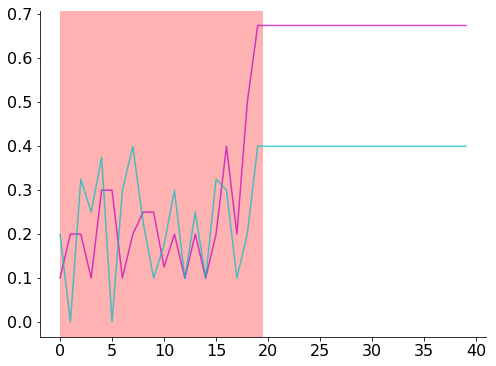

In [7]:
plt.errorbar(range(40), resp_ind[0, :, 0, 3, 0], c='m', alpha=0.7)
plt.errorbar(range(40), resp_ind[1, :, 0, 3, 0], c='c', alpha=0.7)
plt.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
plt.show()
plt.close()

In [9]:
stim = hickle.load('/export/public/ukita/prednet/stim/50frames192x224/MAE_P_deg0.hkl')
print(stim.shape)

stim_ = stim.reshape((10, 50, 192, 224, 3))

(500, 192, 224, 3)


/home/ukita/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


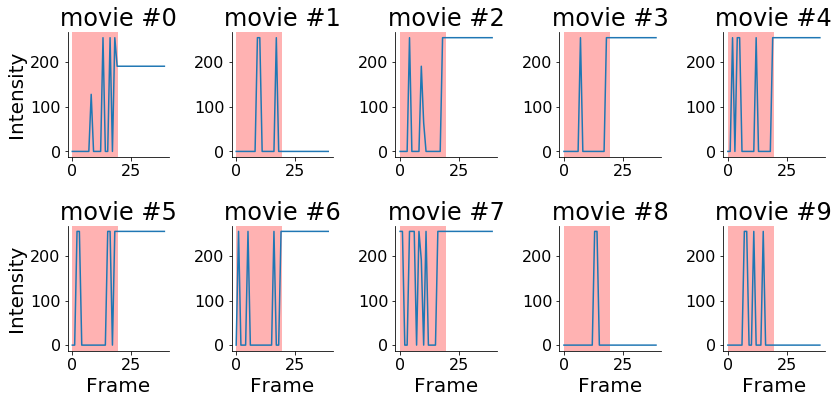

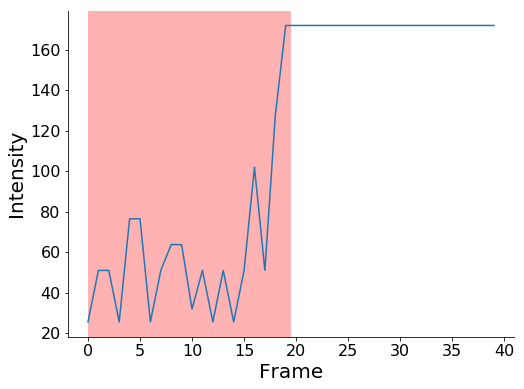

In [19]:
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.plot(stim_[i, 10:50, 0, 3, 0])
    ax.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
    if i in range(5, 10):
        ax.set_xlabel('Frame')
    if i in [0, 5]:
        ax.set_ylabel('Intensity')
    ax.set_title('movie #' + str(i))
plt.tight_layout()
plt.show()
    
plt.plot(stim_[:, 10:50, 0, 3, 0].mean(axis=0))
plt.axvspan(0, stim_frames - 0.5, facecolor='r', alpha=0.3)
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.show()